In [1]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

## Entropy

In [20]:
def entropy(node):
    props = node / node.sum()
    return -np.sum(props * np.log2(props))

In [21]:
def loss(split):
    n1, n2 = split
    return ((n1.sum() * entropy(n1) + n2.sum() * entropy(n2))
            / split.sum())

In [40]:
def p0(node): return node[0] / node.sum()

In [22]:
N = 100
parents = np.array([[k, N - k] for k in range(1, N)])
ps = parents[:, 0] / N
entropys = [entropy(n) for n in parents]

Text(0.5, 1.0, 'Entropy for all possible two-class nodes')

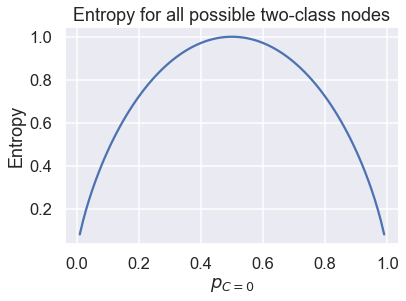

In [28]:
sns.lineplot(ps, entropys)
plt.xlabel(r'$p_{C=0}$')
plt.ylabel(r'Entropy')
plt.title('Entropy for all possible two-class nodes')

In [86]:
def plot_split_entropy(split):
    parent = split.sum(axis=0)
    child_p = [p0(split[0]), p0(split[1])]
    child_S = [entropy(split[0]), entropy(split[1])]
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(ps, entropys)
    plt.scatter(p0(parent), entropy(parent), s=150, label='Parent')
    
    plt.scatter(child_p, child_S, s=150, label='Children')
    plt.plot(child_p, child_S, linestyle='--')
    plt.scatter(p0(parent), loss(split), s=150, label='Split entropy')
    plt.plot([p0(parent), p0(parent)], [loss(split), entropy(parent)],
             label='Info gain')
    
    plt.xlabel(r'$p_{C=0}$')
    plt.ylabel(r'Entropy')
    plt.legend()

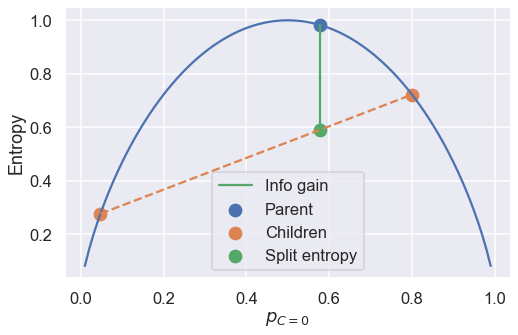

In [87]:
s = np.array([
    [1, 20], [40, 10],
])

plot_split_entropy(s)

## Decision Trees

In [88]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
cancer = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
cancer['bias'] = 1.0
# Target data_dict['target'] = 0 is malignant; 1 is benign
cancer['malignant'] = 1 - data_dict['target']
cancer

,mean radius,mean texture,mean perimeter,mean area,...,worst symmetry,worst fractal dimension,bias,malignant
0,17.99,10.38,122.80,1001.0,...,0.46,0.12,1.0,1
1,20.57,17.77,132.90,1326.0,...,0.28,0.09,1.0,1
2,19.69,21.25,130.00,1203.0,...,0.36,0.09,1.0,1
...,...,...,...,...,...,...,...,...,...
566,16.60,28.08,108.30,858.1,...,0.22,0.08,1.0,1
567,20.60,29.33,140.10,1265.0,...,0.41,0.12,1.0,1
568,7.76,24.54,47.92,181.0,...,0.29,0.07,1.0,0


In [89]:
df_interact(cancer)

interactive(children=(IntSlider(value=0, description='row', max=569, step=7), IntSlider(value=0, description='…

(569 rows, 32 columns) total


In [90]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cancer, test_size=0.25, random_state=100)
print("Training Data Size: ", len(train))
print("Test Data Size: ", len(test))

Training Data Size:  426
Test Data Size:  143


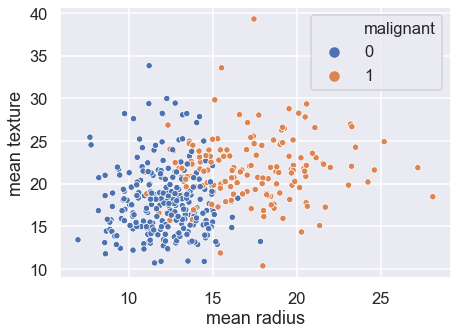

In [91]:
plt.figure(figsize=(7, 5))
sns.scatterplot('mean radius', 'mean texture', hue='malignant',
                s=40, data=train)

In [98]:
def points_for_boundary(X, clf):
    x_min, x_max = X['mean radius'].agg(['min', 'max'])
    y_min, y_max = X['mean texture'].agg(['min', 'max'])
    xs = np.linspace(x_min, x_max, 100)
    ys = np.linspace(y_min, y_max, 100)
    points = pd.DataFrame({
        'xs': np.tile(xs, len(ys)),
        'ys': np.repeat(ys, len(xs)),
    })
    return points.assign(pred=clf.predict(points))

In [99]:
def decision_boundary(pred):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    sns.scatterplot('xs', 'ys', hue='pred', data=pred, alpha=0.2, s=40,
                    legend=False)
    sns.scatterplot('mean radius', 'mean texture', hue='malignant',
                    s=60, legend=False, data=train)
    
    plt.subplot(122)
    sns.scatterplot('xs', 'ys', hue='pred', data=pred, s=40, legend=False)

In [93]:
from sklearn.linear_model import LogisticRegression

X_train = train[['mean radius', 'mean texture']]
y_train = train['malignant']

0.8849765258215962


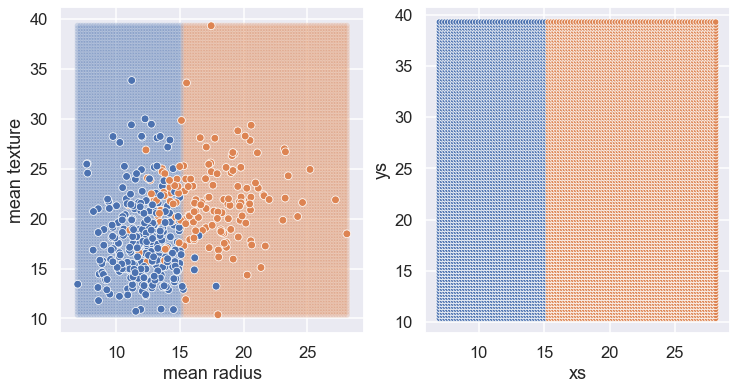

In [111]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf.fit(X_train, y_train)

pred = points_for_boundary(X_train, clf)
decision_boundary(pred)
print(clf.score(X_train, y_train))

0.892018779342723


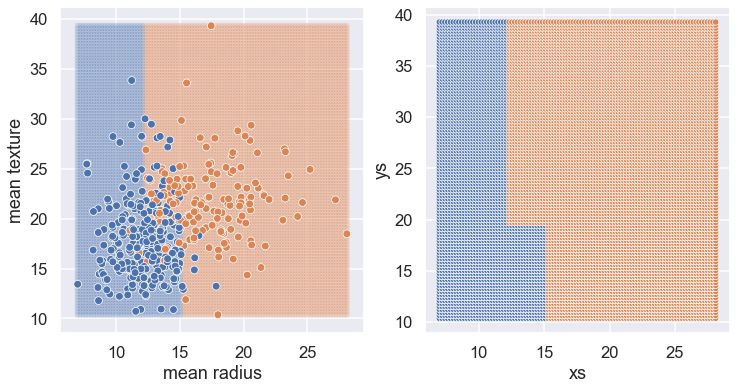

In [112]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf.fit(X_train, y_train)

pred = points_for_boundary(X_train, clf)
decision_boundary(pred)
print(clf.score(X_train, y_train))

1.0


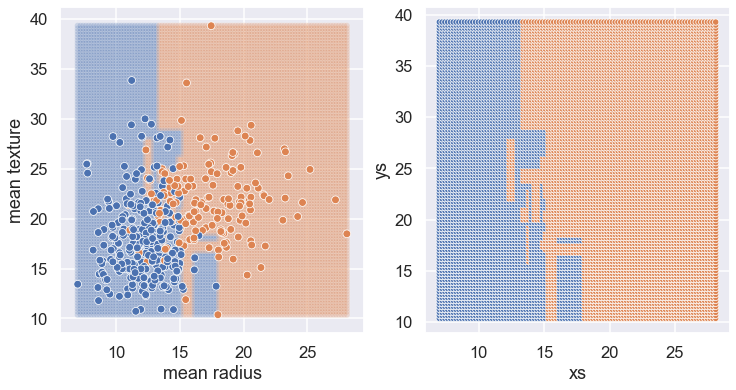

In [113]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)

pred = points_for_boundary(X_train, clf)
decision_boundary(pred)
print(clf.score(X_train, y_train))